<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.4
# *PCA Lab*

**In this lab, we will:**
- Explore how PCA is related to correlation.
- Use PCA to perform dimensionality reduction.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [1]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pointbiserialr
%matplotlib inline

In [2]:
breast_cancer_csv = 'data/breast-cancer-wisconsin-data.csv'
cancer = pd.read_csv(breast_cancer_csv)
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### 2. EDA 

Explore dataset. Clean data. Find correlation. 

In [3]:
# Drop id and vestigial column at end
cancer.drop(['id','Unnamed: 32'], axis=1, inplace=True)

In [4]:
# Check for null values and datatypes
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [5]:
# Change 'diagnosis' to a binary
cancer.diagnosis = cancer.diagnosis == 'M'

print(cancer.diagnosis.dtypes)

bool


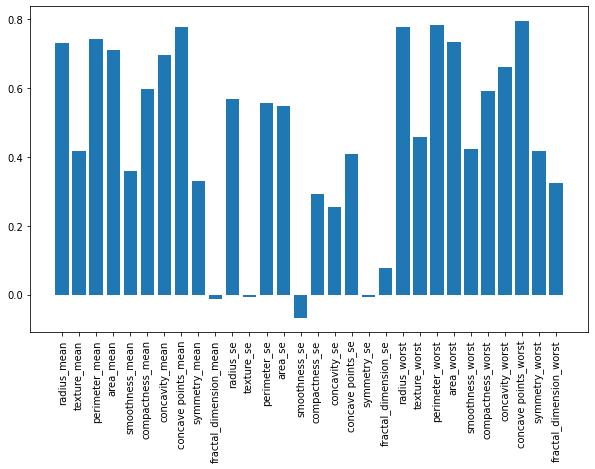

In [6]:
# Plot correlation of each feature with the diagnosis
correlation = []
columnnames = cancer.drop('diagnosis', axis=1).columns
for i in columnnames:
    correl = pointbiserialr(cancer['diagnosis'], cancer[i])
    correlation.append(correl[0])
ax = plt.figure(figsize=(10,6))
ax = plt.bar(columnnames, correlation)
plt.xticks(rotation=90)
plt.show()

### 3. Subset & Normalize

Subset the data to only include all columns except diagnosis. We will be comparing the principal components to age specifically, so we are leaving age out.

In [7]:
# ANSWER
# Assign features
X_unscaled = cancer.drop('diagnosis', axis=1)

# Normalise data with StandardScaler
X = pd.DataFrame(StandardScaler().fit_transform(X_unscaled), columns=X_unscaled.columns)

### Calculate correlation matrix

We will be using the correlation matrix to calculate the eigenvectors and eigenvalues.

In [8]:
# ANSWER
cancer_corr = X.corr()

### 4. Calculate the eigenvalues and eigenvectors from the correlation matrix

numpy has a convenient function to calculate this:

    eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)

In [9]:
# ANSWER
eigenvalues, eigenvectors = np.linalg.eig(cancer_corr)

### 5. Calculate and plot the explained variance

A useful measure is the **explained variance**, which is calculated from the eigenvalues. 

The explained variance tells us how much information (variance) is captured by each principal component.

### $$ ExpVar_i = \bigg(\frac{eigenvalue_i}{\sum_j^n{eigenvalue_j}}\bigg) * 100$$

In [10]:
def calculate_cum_var_exp(eig_vals):
    '''
    Calculate Explained Variance from Eigenvalues
    
    Return a list or array containing the cumulative explained variance 
    '''
    cum_var_exp = ((eig_vals/eig_vals.sum())*100)
    return cum_var_exp

In [11]:
def plot_var_exp(eig_vals):
    
    cum_var_exp = calculate_cum_var_exp(eig_vals)
    
    plt.figure(figsize=(9,7))

    component_number = [i+1 for i in range(len(cum_var_exp))]

    plt.plot(component_number, cum_var_exp, lw=7)

    plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
    plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')

    ax = plt.gca()
    ax.set_xlim([1,30])
    ax.set_ylim([-5,105])

    ax.set_ylabel('cumulative variance explained', fontsize=16)
    ax.set_xlabel('component', fontsize=16)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

    ax.set_title('component vs cumulative variance explained\n', fontsize=20)

    plt.show()

### 6. Using sklearn For PCA

    from sklearn.decomposition import PCA
    
- Create an instance of PCA
- Fit X
- Plot the explained variance
- Define n_components
    - n_component
- Apply dimensionality reduction to X
    - transform
- Create PairPlot of PCA

In [12]:
# ANSWER
# Create an instance of PCA
model = PCA()
# Fit Xs
model_fit = model.fit(X)

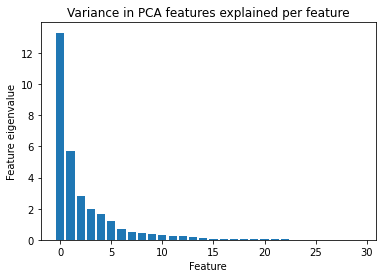

In [13]:
# ANSWER
# Plot explained_variance_
plt.bar(range(len(model_fit.explained_variance_)), model_fit.explained_variance_)
plt.title('Variance in PCA features explained per feature')
plt.ylabel('Feature eigenvalue')
plt.xlabel('Feature')
plt.show()

In [14]:
# ANSWER
# Apply dimensionality reduction to Xs using transform
# Create an instance of PCA
model_new = PCA(n_components=5)
# Fit Xs
model_new_fit = model_new.fit(X)

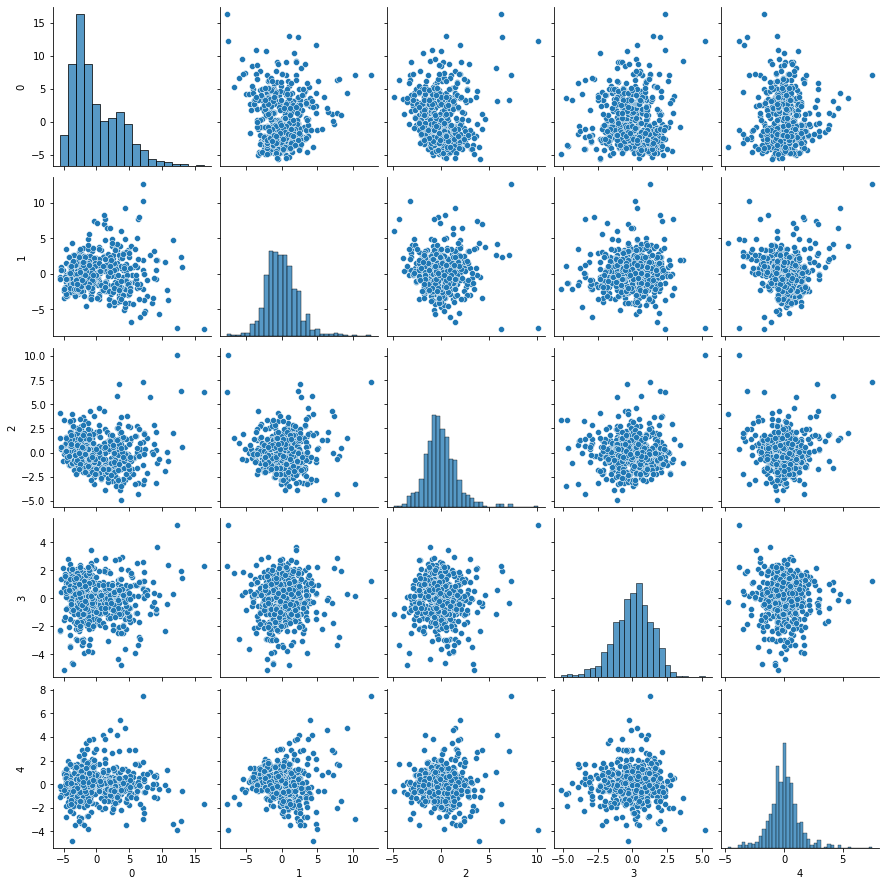

In [15]:
# ANSWER
# Create PairPlot of PCA
PCA_features = model_new_fit.transform(X)
sn.pairplot(pd.DataFrame(PCA_features))
plt.show()

### 7. Split Data to 80/20 and Use PCA you gon in 6 as X

Split data 80/20 and Use KNN to find score.

In [16]:
# ANSWER
# Split Data
X_train, X_test, y_train, y_test = train_test_split(PCA_features, cancer.diagnosis, test_size=0.2)

# Create and fit KNN model
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_fit = KNN_model.fit(X_train, y_train)

# Find score using test data
y_pred = KNN_fit.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [17]:
# ANSWER
print('The accuracy score of the model with 5 PCA features is', accuracy)

The accuracy score of the model with 5 PCA features is 0.9824561403508771


**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)

[Breast Cancer Machine Learning Prediction](https://gtraskas.github.io/post/breast_cancer/)

[Understanding PCA (Principal Component Analysis) with Python](https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21)



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



